# Seat availability at La Permanence: forecasting using random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

In this notebook we use random forests to predict the number of available seats.  

## Imports

In [1]:
import os
import re
import tqdm

import pytz
import datetime

import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"

# Colors for plotting
# COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
# COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Functions  

Most (if not all) of the following functions are taken from the [fastai](https://github.com/fastai/fastai/blob/master/old/fastai/structured.py) (*version 0.7*) library:

In [3]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
    
    
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

Note: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

The columns are:
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
`YYYY=year`,
`MM=month`,
`DD=day`,
`hh=hour`,
`mm=minute`,
`ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).

In [4]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

In [5]:
%%time
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)
if filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1000000))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1000))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=',', dtype={'Moulin': np.uint8, 'Alésia': np.uint8})
raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)
# raw_data = pd.read_csv(filepath, sep=',', dtype={'Moulin': np.uint8, 'Alésia': np.uint8}, parse_dates=['timestamp'], infer_datetime_format=True)

Size of data file: 960KB.
Loading data...
CPU times: user 365 ms, sys: 9.47 ms, total: 375 ms
Wall time: 373 ms


## Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [6]:
%time
availability = raw_data.copy()

availability['timestamp'] = availability['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))
availability.set_index("timestamp", inplace=True)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 31 µs


## Time regularization

As explained in notebook `la-permanence-EDA.ipynb`, the data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [7]:
availability = availability.resample(RULE).mean().interpolate()

## Visualizating the time series

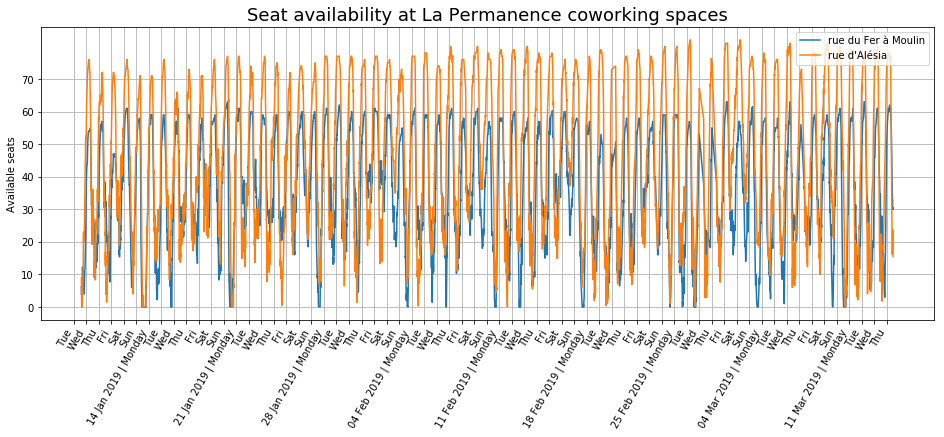

In [8]:
fig, ax = plt.subplots(figsize=(16, 6));
# availability.set_index('timestamp')[['Moulin', 'Alésia']].plot(ax=ax);
availability[['Moulin', 'Alésia']].plot(ax=ax);

ax.set_title("Seat availability at La Permanence coworking spaces", fontsize=18)

ax.set_ylabel("Available seats");
ax.set_yticks(range(0, 80, 10))

ax.axes.get_xaxis().label.set_visible(False);
# ts_min = availability['timestamp'].min()
# ts_max = availability['timestamp'].max()
ts_min = availability.index.min()
ts_max = availability.index.max()
availability_date_range = pd.date_range(ts_min.date(), ts_max.date());
ax.set_xticks(availability_date_range);

ax.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in availability_date_range])
ax.tick_params(axis='x', labelrotation=60)
ax.set_yticks(range(0, 80, 10))

ax.legend(["rue du Fer à Moulin", "rue d'Alésia"], loc="upper right");
ax.grid()
# plt.savefig("La-Permanence-availability.png")

## Expanding date information

Following [fastai](http://course18.fast.ai/lessonsml1/lesson2.html), the next cell extracts particular date fields from a complete datetime for the purpose of constructing categoricals:

In [9]:
availability.reset_index('timestamp', inplace=True)
timestamps = availability.loc[:, ['timestamp']]
add_datepart(availability, 'timestamp', time=True)

availability.drop('timestampSecond', axis=1, inplace=True)

## Separating dependent from independent variables  


One question is whether the availability at one of the locations contains any information about the availabilty at the other location.  

One option is to keep the availability at the other location as a dependent variable (a feature).  But this means that in forecasting the availability one needs to know that at the other location.  In conclusion, we will only use `timestamp` in our forecast.  

In [10]:
df= availability.drop(['Moulin', 'Alésia'], axis=1)

y_moulin = availability['Moulin'].copy()
y_alesia = availability['Alésia'].copy()

## Splitting data into training and validation sets  

In [11]:
n_valid = 2*7*24*(60 // RESOL)  # validation period is two weeks
n_trn = availability.shape[0] - n_valid

X_train, X_valid = split_vals(df, n_trn)

y_train_moulin, y_valid_moulin = split_vals(y_moulin, n_trn)
y_train_alesia, y_valid_alesia = split_vals(y_alesia, n_trn)


# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

## Visualizing the training and validation data

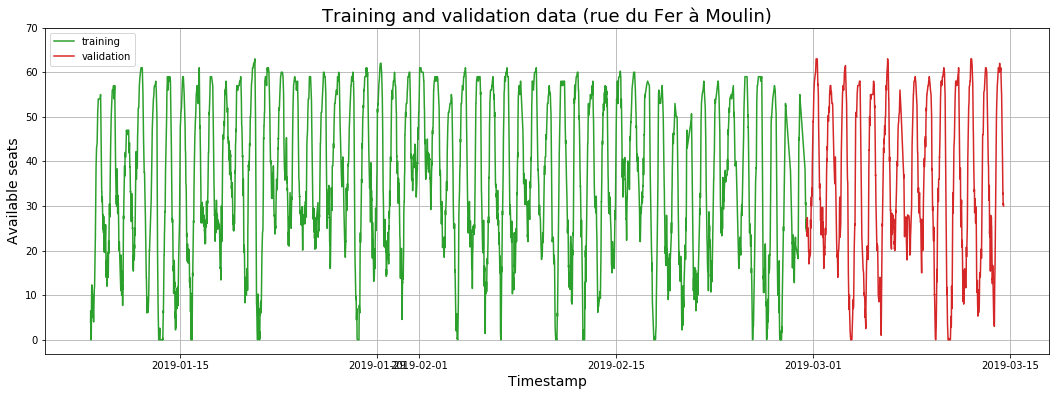

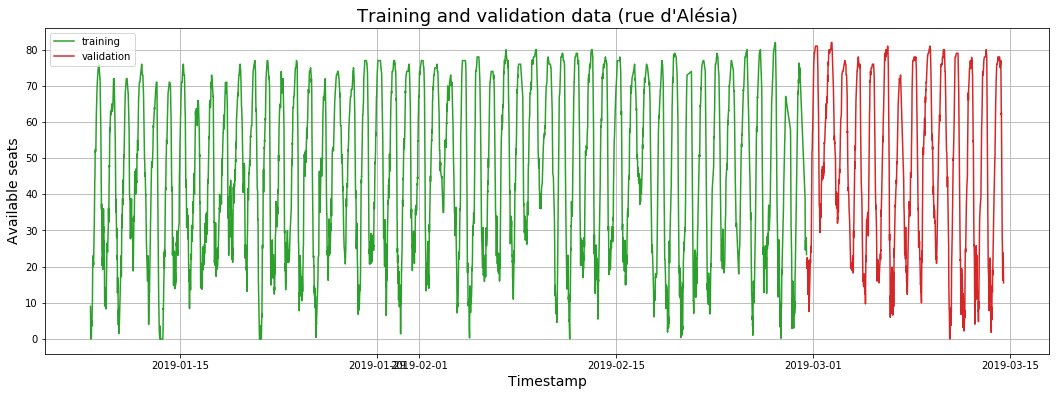

In [43]:
fig, ax = plt.subplots(figsize=(18, 6));
plt.plot(timestamps_train['timestamp'], y_train_moulin, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid_moulin, COL_VALID);
ax.set_title("Training and validation data (rue du Fer à Moulin)", fontsize=18)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['training', 'validation'])
ax.grid();
# plt.savefig("moulin-training-validation-split.png")

fig, ax = plt.subplots(figsize=(18, 6));
plt.plot(timestamps_train['timestamp'], y_train_alesia, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid_alesia, COL_VALID);
ax.set_title("Training and validation data (rue d'Alésia)", fontsize=18)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 90, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['training', 'validation'])
ax.grid();
# plt.savefig("alesia-training-validation-split.png")

## Forecast using random forests

### Using default values

We first use random forests with default values for a quick evaluation of the method.

Location **rue du Fer à Moulin**:

In [13]:
m_moulin = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m_moulin.fit(X_train, y_train_moulin)
print([rmse(m_moulin.predict(X_train), y_train_moulin), rmse(m_moulin.predict(X_valid), y_valid_moulin),
                m_moulin.score(X_train, y_train_moulin), m_moulin.score(X_valid, y_valid_moulin)])
y_predict_moulin = m_moulin.predict(X_valid)

CPU times: user 221 ms, sys: 8.34 ms, total: 229 ms
Wall time: 117 ms
[0.6517305703136859, 9.87934996032576, 0.9985729887053016, 0.7076841811251504]


Location **rue d'Alésia**:

In [14]:
m_alesia = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m_alesia.fit(X_train, y_train_alesia)
print([rmse(m_alesia.predict(X_train), y_train_alesia), rmse(m_alesia.predict(X_valid), y_valid_alesia),
                m_alesia.score(X_train, y_train_alesia), m_alesia.score(X_valid, y_valid_alesia)])
y_predict_alesia = m_alesia.predict(X_valid)

CPU times: user 231 ms, sys: 7.36 ms, total: 238 ms
Wall time: 116 ms
[0.8433289146482953, 17.832048054236875, 0.9986483752847916, 0.4530481995489714]


The results are not amazing, but random forests with default values are still better than just guessing the average values (the $R^2$ score is positive).

### Visualizing predictions

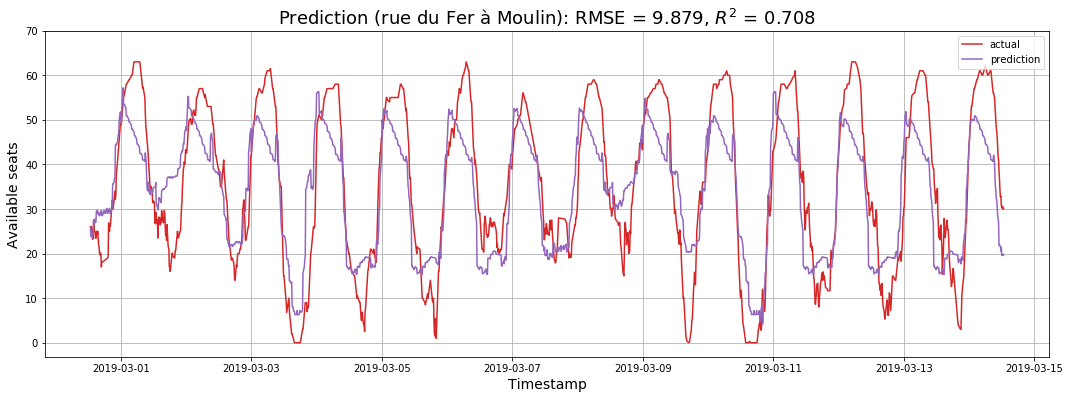

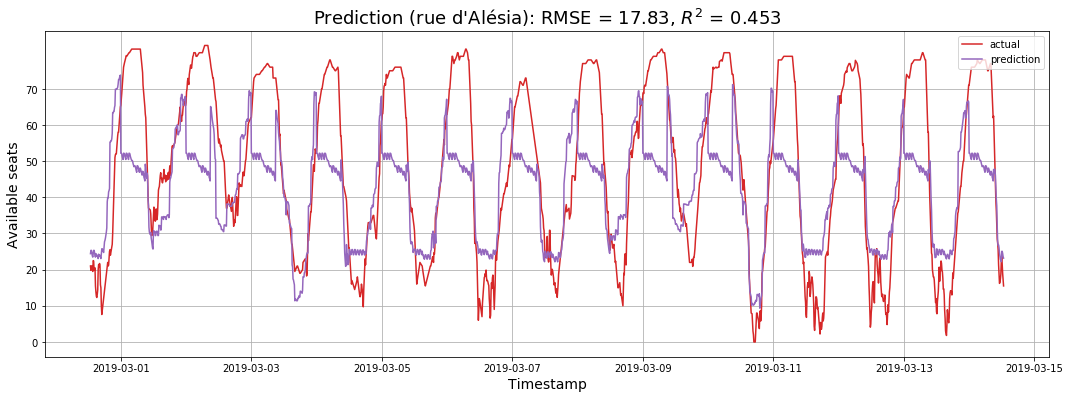

In [15]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid_moulin, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict_moulin, COL_PREDICT);
ax.set_title(
    "Prediction (rue du Fer à Moulin): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m_moulin.predict(X_valid), y_valid_moulin),
        m_moulin.score(X_valid, y_valid_moulin)
    ),
    fontsize=18
)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();

fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid_alesia, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict_alesia, COL_PREDICT);
ax.set_title(
    "Prediction (rue d'Alésia): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m_alesia.predict(X_valid), y_valid_alesia),
        m_alesia.score(X_valid, y_valid_alesia)
    ),
    fontsize=18
)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();

Random forests do pick up some of the seasonal behaviour in the data, in a conservative way in particular with the data from rue d'Alésia.  That is nevertheless quite encouraging.

### Preliminary conclusion

It is reasonable to hope that the model can be improved by adjusting the parameters.


### Tuning parameters 

There are many parameters in `sklearn.RandomForestRegressor` that can be adjusted in order to improve the predictions.  We will focus on the following:  
-  the number of trees: `nb_estimators`;  
-  the minimum number of samples required to be at a leaf node: `min_leaves_sample` (alternatively, or additional, the maximum depth of the trees);  
-  the number of features to consider when looking for the best split: `max_features`.  

For simplicity we will concentrate our investigations on the data for the location at rue de Fer à Moulin:

In [36]:
y = y_moulin.copy()
y_train = y_train_moulin.copy()
y_valid = y_valid_moulin.copy()

### The number of trees  

First we consider the number of trees:

In [17]:
NB_TREES = [2**i for i in range(0, 8)]
NB_TREES

[1, 2, 4, 8, 16, 32, 64, 128]

In [18]:
# NB_TREES = (1, 2, 5, 10, 20, 50, 100, 200)
NB_TREES = range(1, 25)
# NB_TREES = [2**i for i in range(0, 6)]
# NB_TREES = [i**2 for i in range(1, 6)]

train_rmse = []
valid_rmse = []
train_r2 = []
valid_r2 = []

for n in tqdm.tqdm(NB_TREES):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n)
    m.fit(X_train, y_train)
    train_rmse.append(rmse(m.predict(X_train), y_train))
    valid_rmse.append(rmse(m.predict(X_valid), y_valid))
    train_r2.append(m.score(X_train, y_train))
    valid_r2.append(m.score(X_valid, y_valid))



100%|██████████| 24/24 [00:13<00:00,  1.73it/s]


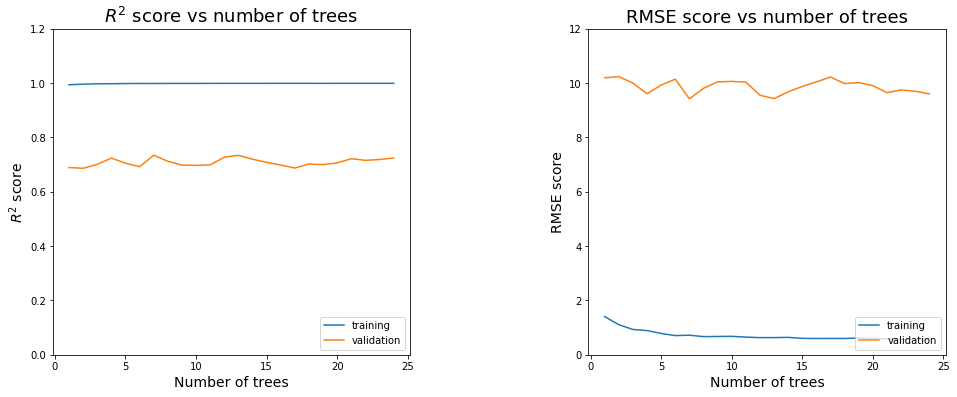

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6));
plt.subplots_adjust(wspace=.5);

ax1.plot(NB_TREES, train_r2)
ax1.plot(NB_TREES, valid_r2)

ax1.set_title("$R^2$ score vs number of trees", fontsize=18)
ax1.set_ylabel("$R^2$ score", fontsize=14);
ax1.set_ylim([0, 1.2]);
ax1.set_xlabel("Number of trees", fontsize=14);
ax1.legend(['training', 'validation'], loc='lower right');

ax2.plot(NB_TREES, train_rmse)
ax2.plot(NB_TREES, valid_rmse)

ax2.set_title("RMSE score vs number of trees", fontsize=18)
ax2.set_ylabel("RMSE score", fontsize=14);
ax2.set_ylim([0, 12]);
ax2.set_xlabel("Number of trees", fontsize=14);
ax2.legend(['training', 'validation'], loc='lower right');

This suggests that beyond 5 trees the random forest is not significantly improved.  We fix this parameter to 10, which is (currently) the default value in `scikit-learn`'s `RandomForestRegressor`:

In [20]:
nb_trees = 10

### Minimum number of leaves and maximum number of features

Next we perform a **grid search** over the parameters `min_samples_leaf` and `max_features` to find an optimal choice.  

From experimentation lower values of `max_features` can be discarded and we define:

In [21]:
# MAX_FEATURES = range(6, 16, 2)
MAX_FEATURES = list(range(len(df.columns) // 2, len(df.columns)+1, 2))
if not len(df.columns) in MAX_FEATURES:
    MAX_FEATURES.append(len(df.columns))

As for the mininum number of leaves, we will try:

In [22]:
MIN_LEAVES = (1, 3, 5, 10) + tuple(range(25, 525, 25))  # 225 425 625

We run the grid search:

In [23]:
performance_list = []

for i, j in tqdm.tqdm([(x, y) for x in MIN_LEAVES for y in MAX_FEATURES]):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=i, max_features=j)
    m.fit(X_train, y_train)
    D = {
        'min leaves': i,
        'max features': j,
        'rmse': rmse(m.predict(X_valid), y_valid),
        'R2': m.score(X_valid, y_valid)
    }
    performance_list.append(D)

100%|██████████| 120/120 [00:40<00:00,  2.96it/s]


In [24]:
performance = pd.DataFrame(performance_list)[['min leaves', 'max features', 'rmse', 'R2']]

Calculate RMSE values and $R^2$ scores:

In [25]:
df_rmse = pd.pivot_table(performance, index='min leaves', columns='max features', values='rmse')
df_r2 = pd.pivot_table(performance, index='min leaves', columns='max features', values='R2')

Plot heatmaps for these two metrics, with different color maps so that **darker colors mean better results**:

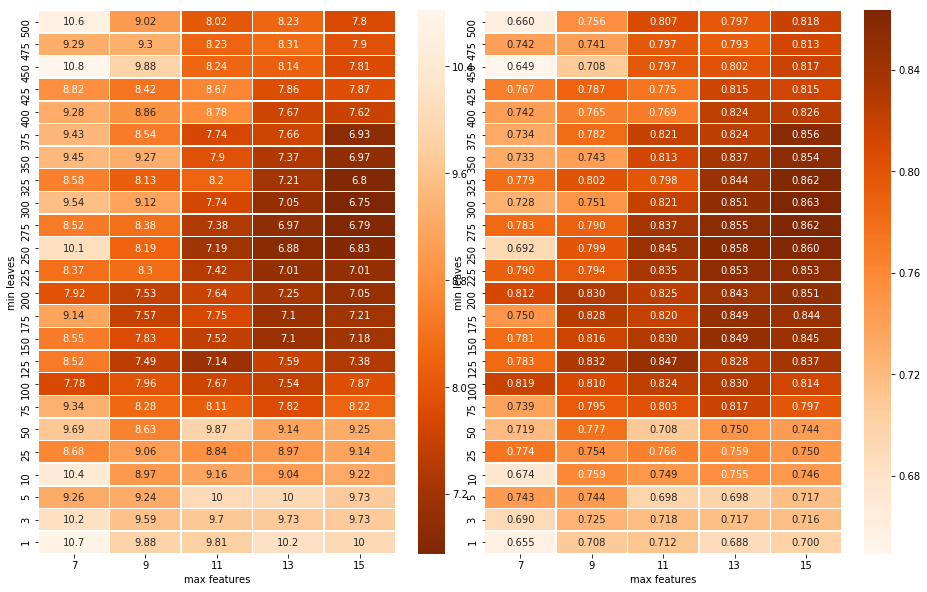

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10));
plt.subplots_adjust(wspace=0);
sns.heatmap(df_rmse.sort_index(ascending=False), annot=True, cmap="Oranges_r", linewidths=.5, fmt='.3g', ax=ax1);
sns.heatmap(df_r2.sort_index(ascending=False), annot=True, cmap="Oranges", linewidths=.5, fmt='.3f', ax=ax2);

From these heatmaps we can draw a number of conclusions.

### Both the RMSE value and the $R^2$ score provide the same qualitative insight

It seems that both metrics provide the same qualitative information: the optimal pair of values for `min_samples_leaf` and `max_features` is the same regardless of whether we look at RMSE or $R^2$ (although the optimizer will generally change from one trial to the next).  We verify this in the following way:

In [27]:
sort_rmse = performance.sort_values('rmse')[['min leaves', 'max features']]
sort_r2 = performance.sort_values('R2')[['min leaves', 'max features']]

In [28]:
sort_rmse_r2 = pd.merge(
    left=sort_rmse,
    right=sort_r2,
    left_index=True,
    right_index=True
)
# sort_rmse_r2.info()

In [29]:
sort_rmse_r2.isnull().any()  # sum()

## In case of a True, uncomment the following:

# null_columns = sort_rmse_r2.columns[sort_rmse_r2.isnull().any()]
# print(sort_rmse_r2[null_columns].isnull().sum())

min leaves_x      False
max features_x    False
min leaves_y      False
max features_y    False
dtype: bool

In other words the values of RMSE and $R^2$ are ordered in the same way.

### The optimizing pair (`max_features`, `mim_samples_leaf`)

From the heatmaps, we infer that  
1. a higher number of features generally provides better results; and that
1. better results are obtained for `min_samples_leaf` in the broad range 150 - 300.

From the run above we can extract the optimizer:

In [30]:
min_leaves, max_features = tuple(sort_rmse.iloc[0])
min_leaves, max_features

(300, 15)

In [37]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves, max_features=max_features)
m.fit(X_train, y_train)
y_predict = m.predict(X_valid)

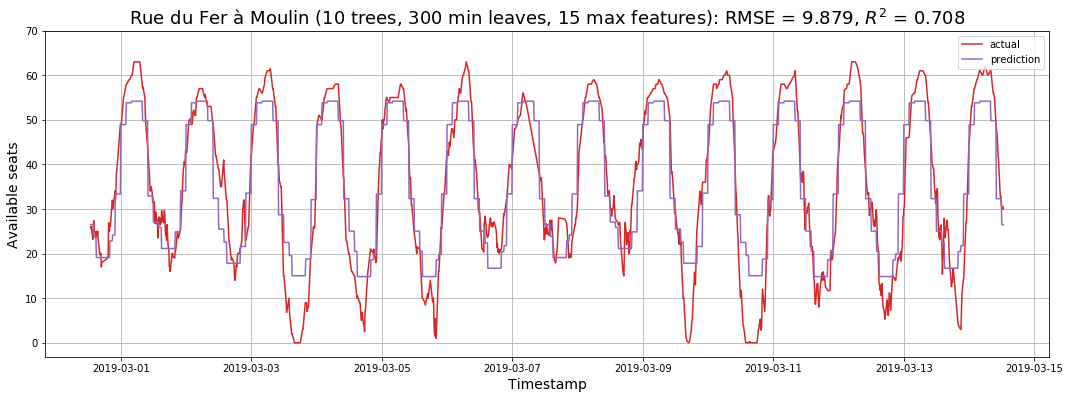

In [39]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin ({2} trees, {3} min leaves, {4} max features): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m_moulin.predict(X_valid), y_valid_moulin),
        m_moulin.score(X_valid, y_valid_moulin),
        nb_trees,
        min_leaves,
        max_features
    ),
    fontsize=18
)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png")

## Rue d'Alésia

Finally we run the model on the data from the location at rue d'Alésia:

In [40]:
y = y_alesia.copy()
y_train = y_train_alesia.copy()
y_valid = y_valid_alesia.copy()

In [41]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, min_samples_leaf=min_leaves, max_features=max_features)
m.fit(X_train, y_train)
y_predict = m.predict(X_valid)

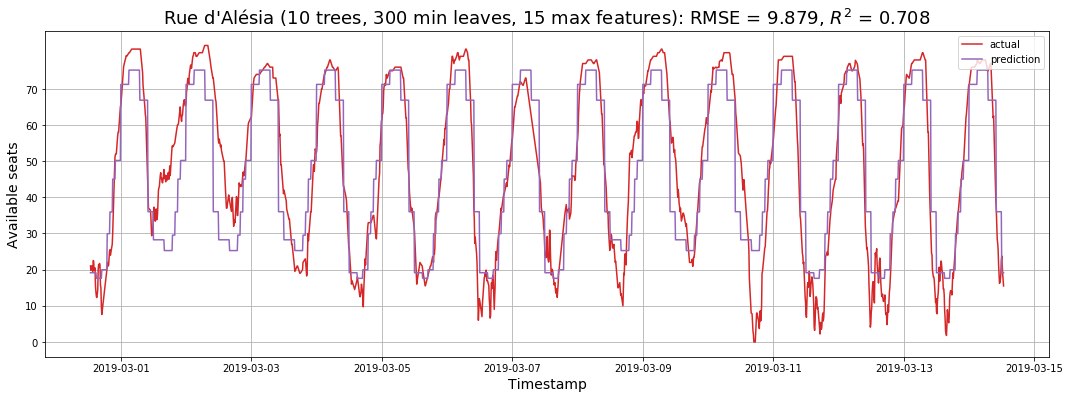

In [42]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue d'Alésia ({2} trees, {3} min leaves, {4} max features): RMSE = {0:.4g}, $R^2$ = {1:.3g}".format(
        rmse(m_moulin.predict(X_valid), y_valid_moulin),
        m_moulin.score(X_valid, y_valid_moulin),
        nb_trees,
        min_leaves,
        max_features
    ),
    fontsize=18
)
ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("alesia-random-forests.png")

## Conclusion

Random forests are quite good at picking up the general trend but not quite as good in detecting particularly high attendance (low availability) at the coworking spaces.  